## Ноутбук с симуляцией ATL

Если используется GPU, выставить соответствующий флаг

In [4]:
GPU = False
# GPU = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyffs
!pip install pint
!pip install cupy

Импорты:

In [7]:
if GPU:
    import cupy as np
else:
    import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

import os
from PIL import Image, ImageDraw
from pyffs import ffsn, iffsn, ffs_shift, iffs_shift

import pint
u = pint.UnitRegistry()
MAX_INTENS = 256

### compute_carpet: Функция, считающая картину на определенном расстоянии по фотке маски

### compute_ATL: Главная симуляция ATL картины по маске

In [33]:
def my_matmul(a, m):
    if np.isscalar(a):
        return a * m
    else:
        return np.outer(a, m).reshape(len(a), m.shape[0], m.shape[1])
    
def compute_carpet(mask, wavelength, T_x, T_y, z):
    '''
    Функция для вычисления дифракционной картины ATL
    param mask: изображение маски,
    param period: период маски, [ед.], 
    param wavelength: длина волны, [ед.]
    param z: расстояние от картины до маски, [1000 * ед.]

    return: изображение картины
    '''

    mask_array = np.sqrt(np.array(mask))
    
    N = mask_array.shape[0]
    n = (N - 1) // 2

    T = np.array([T_x, T_y])
    # T = np.array([float(T_x / u.mm), float(T_y / u.mm)])
    T_c = T / 2
    N_FS = [N, N]
    
    F = ffsn((mask_array), T, T_c, N_FS)
    f_x = np.reshape(np.arange(-n, n + 1) / T[0], (1, -1))
    f_y = np.reshape(np.arange(-n, n + 1) / T[1], (-1, 1))

    # z = float(z / u.mm)
    # wavelength = np.array(wavelength / u.mm)

    H = np.exp(-1j * np.pi * z * my_matmul(wavelength, (np.power(f_x, 2) + np.power(f_y, 2))))
    result_array = (iffsn((F * H), T, T_c, N_FS, axes=[1, 2]))
    return np.square(np.absolute(result_array))

def compute_atl(mask, T_x, T_y, wl, delta_wl):
    grid_size = 500
    wl_grid = np.linspace(wl - delta_wl, wl + delta_wl, grid_size)
    # freq_grid = u.speed_of_light / wl_grid
    # delta_freq = freq_grid[1] - freq_grid[0]
    d_wl = wl_grid[1] - wl_grid[0]

    grid = np.linspace(-2, 2, grid_size)
    if GPU:
        intens = sps.norm.pdf(grid.get())
    else:
        intens = sps.norm.pdf(grid)
    
    z_A = 2 * max(T_x, T_y) ** 2 / delta_wl
    carp = compute_carpet(mask, wl_grid, T_x, T_y, 2 * z_A)# * d_wl
    return np.average(carp, axis=0, weights=intens)# * MAX_INTENS

### Удобные функции для визуализации результата

In [3]:
def periodic_image(arr, reps):
    pic = np.tile(arr, (reps, reps))
    return Image.fromarray(pic)

def frame_plot(arr, ax):
    rectX = np.linspace(0, 1, arr.shape[0])
    rectY = np.linspace(0, 1, arr.shape[1])
    x, y = np.meshgrid(rectX, rectY)
    if GPU:
        ax.pcolormesh(x.get(), y.get(), arr.get())
    else:
        ax.pcolormesh(x, y, arr)

def check_dataset(im_num):
  sims = np.load('/content/drive/MyDrive/simulations.npy')
  masks = np.load('/content/drive/MyDrive/dataset.npy')
  fig, ax = plt.subplots(2, im_num, figsize=(im_num * 4, 8))
  fig.tight_layout()
  index = np.random.randint(0, sims.shape[0], size=im_num)
  for i in range(im_num):
    frame_plot(sims[index[i]], ax[1, i])
    frame_plot(masks[index[i]], ax[0, i])
  fig.show()

Пробуем функцию

In [9]:
wl = 13.5 * u.nm
delta_wl = 0.04 * wl
p = 1 * u.um

wl = float(wl / u.mm)
delta_wl = float(delta_wl / u.mm)
p = float(p / u.mm)

In [34]:
mask = np.array(Image.open("/content/drive/MyDrive/images/im10.png").convert("L"))

result = compute_atl(mask, p, p, wl, delta_wl)

In [36]:
np.min(result)

0.3245327054483763

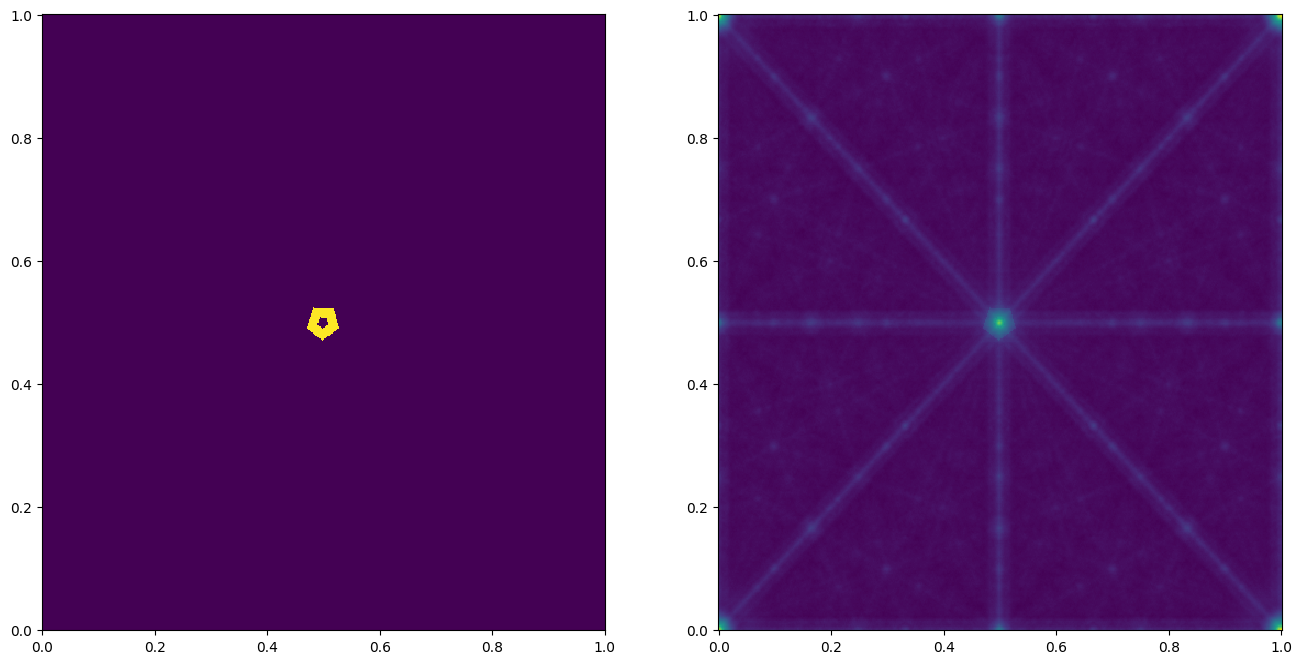

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(np.array(mask), ax=ax[0])
frame_plot(result, ax=ax[1])

In [ ]:
masks = np.load('/content/drive/MyDrive/dataset.npy', allow_pickle=True)
pics = []

In [ ]:
for i in range(masks.shape[0] // 2):
  pics.append(compute_atl(masks[i], p, p, wl, d_wl).get())

In [ ]:
for i in range(masks.shape[0] // 2, masks.shape[0]):
  pics.append(compute_atl(masks[i], p, p, wl, d_wl).get())

In [ ]:
np.save('/content/drive/MyDrive/simulations.npy', pics)

In [11]:
sims = np.load('/content/drive/MyDrive/simulations1.npy')

In [17]:
sims_int = sims.astype(np.int8)

In [21]:
sims[0][256]

array([-0.00214996, -0.00208252, -0.00199267, -0.0019206 , -0.00185802,
       -0.00181766, -0.00179998, -0.00177691, -0.00171715, -0.00169296,
       -0.00167812, -0.00162536, -0.00159768, -0.00158448, -0.00157366,
       -0.00157746, -0.00155884, -0.00155301, -0.00154782, -0.00154887,
       -0.00155094, -0.00156501, -0.00155978, -0.00153653, -0.00153776,
       -0.00152739, -0.00153664, -0.00153956, -0.00155697, -0.00153681,
       -0.00156134, -0.00157402, -0.00156188, -0.00154443, -0.0015258 ,
       -0.00152431, -0.00152579, -0.00153968, -0.00154547, -0.00151531,
       -0.00151783, -0.00149465, -0.00150151, -0.00149363, -0.0015039 ,
       -0.00153118, -0.00153698, -0.00155682, -0.00155521, -0.00158357,
       -0.00158271, -0.00159673, -0.00157971, -0.00157049, -0.00157629,
       -0.00155965, -0.0015798 , -0.00160807, -0.00163064, -0.00163512,
       -0.001638  , -0.00164608, -0.00166362, -0.00164505, -0.00162929,
       -0.00162078, -0.00164808, -0.00165138, -0.00165381, -0.00

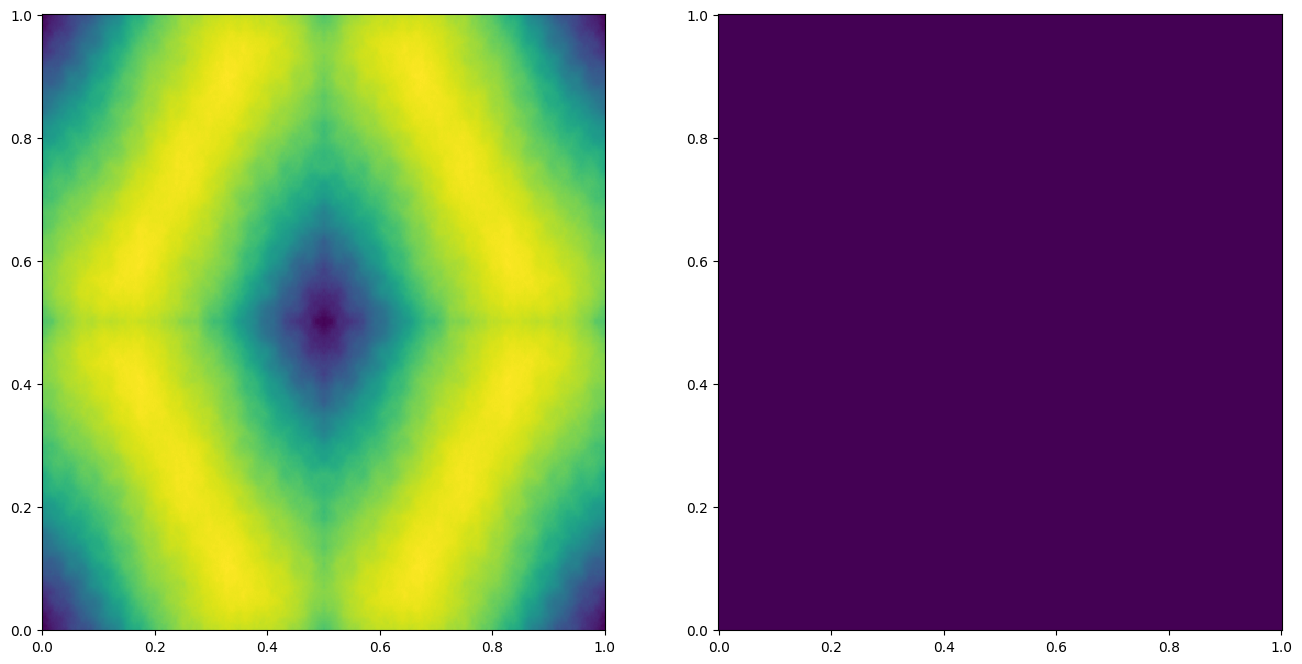

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
frame_plot(sims[100], ax=ax[0])
frame_plot(sims_int[1], ax=ax[1])

In [15]:
np.save('/content/drive/MyDrive/simulations1_int.npy', sims_int)

In [26]:
np.min(sims[100])

-0.0038914726612677528

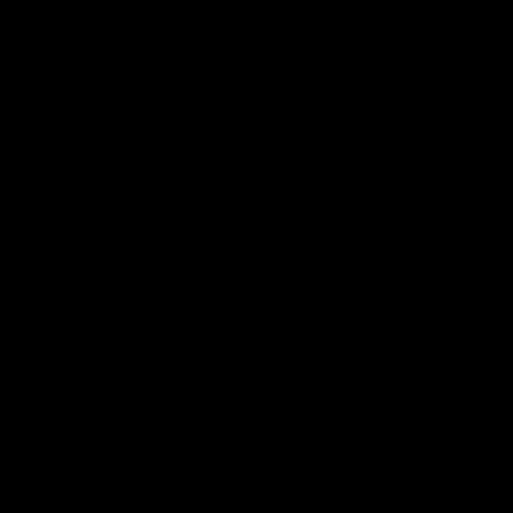

In [23]:
im = Image.fromarray(sims[100])
im = im.convert('L')
# im.save('/content/drive/MyDrive/prediction_test/im.png')
im.show()